In [27]:
##-----------------------------------------------------------
## 1. Thư viện
##-----------------------------------------------------------
import joblib as jlb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sbn
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

In [28]:
##-----------------------------------------------------------
## 2. Đọc dữ liệu
##-----------------------------------------------------------
folder = '../'
data = pd.read_csv(folder + '../Data/Shopping.csv')
print("Dữ liệu ban đầu:")
print(data.head())

## Quan sát sơ bộ thuộc tính Genre
print('Thuộc tính Genre:', Counter(data.Genre))

Dữ liệu ban đầu:
   CustomerID   Genre  Age  Annual Income  Spending Score
0           1    Male   19             15              39
1           2    Male   21             15              81
2           3  Female   20             16               6
3           4  Female   23             16              77
4           5  Female   31             17              40
Thuộc tính Genre: Counter({'Female': 112, 'Male': 88})


In [29]:
##-----------------------------------------------------------
## 3. Tiền xử lý
##-----------------------------------------------------------
# Mã hóa thuộc tính phân loại (Genre)
data = pd.get_dummies(data, columns=['Genre'], dtype='int', drop_first=True)

# Chỉ lấy các cột đặc trưng cần thiết
x = data[['Age', 'Annual Income', 'Spending Score', 'Genre_Male']]

# Chuẩn hóa dữ liệu để tránh lệch scale
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

print(data.head())

   CustomerID  Age  Annual Income  Spending Score  Genre_Male
0           1   19             15              39           1
1           2   21             15              81           1
2           3   20             16               6           0
3           4   23             16              77           0
4           5   31             17              40           0


## 1. **Dendrogram**

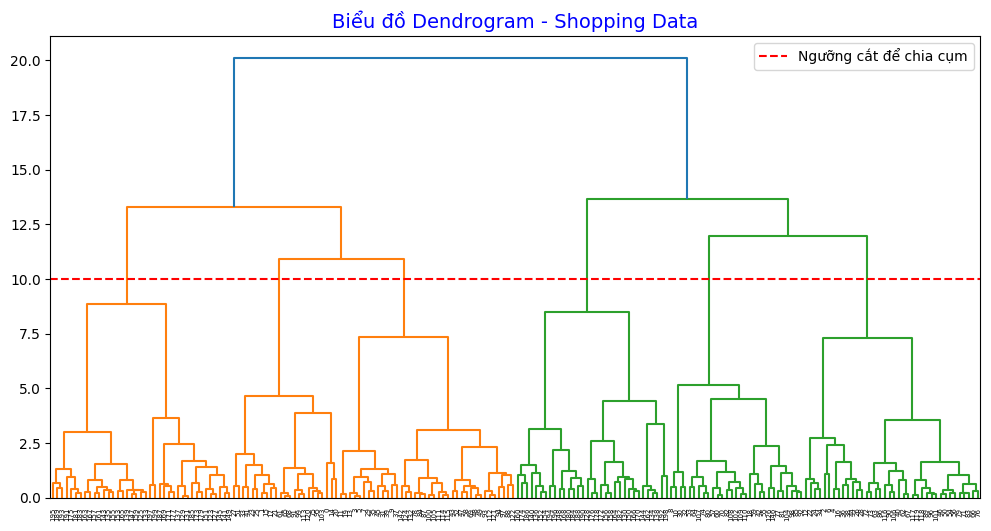

['..//Output/Dendrogram.mdl']

In [30]:
##-----------------------------------------------------------
## 4. Dendrogram (Cây phân cấp)
##-----------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.title("Biểu đồ Dendrogram - Shopping Data", fontsize=14, color="blue")

linkage_matrix = hierarchy.linkage(x_scaled, method='ward')
dendrogram = hierarchy.dendrogram(linkage_matrix)
plt.axhline(y=10, color='r', linestyle='--', label="Ngưỡng cắt để chia cụm")
plt.legend()
plt.show()

## Lưu lại ma trận phân cấp
jlb.dump(linkage_matrix, folder + '/Output/Dendrogram.mdl')

In [31]:
## Khai thác mô hình đã được xây dựng
model = jlb.load(folder + '/Output/Dendrogram.mdl')

## 2. **Mô hình Agglomerative Clustering**

In [32]:
##-----------------------------------------------------------
## 5. Mô hình HAC (AgglomerativeClustering)
##-----------------------------------------------------------
k = 5
model = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
model.fit(data[['Age', 'Annual Income', 'Spending Score', 'Genre_Male']])

,n_clusters,5
,metric,'euclidean'
,memory,None
,connectivity,None
,compute_full_tree,'auto'
,linkage,'ward'
,distance_threshold,None
,compute_distances,False


In [33]:
##-----------------------------------------------------------
## 6. Gắn nhãn cụm vào dữ liệu
##-----------------------------------------------------------
data['cluster'] = model.labels_

print(f"\nSố lượng phần tử trong mỗi cụm: {Counter(model.labels_)}")
print("\nDữ liệu sau khi gom cụm:")
print(data.head(10))


Số lượng phần tử trong mỗi cụm: Counter({np.int64(0): 83, np.int64(2): 39, np.int64(1): 35, np.int64(4): 23, np.int64(3): 20})

Dữ liệu sau khi gom cụm:
   CustomerID  Age  Annual Income  Spending Score  Genre_Male  cluster
0           1   19             15              39           1        4
1           2   21             15              81           1        3
2           3   20             16               6           0        4
3           4   23             16              77           0        3
4           5   31             17              40           0        4
5           6   22             17              76           0        3
6           7   35             18               6           0        4
7           8   23             18              94           0        3
8           9   64             19               3           1        4
9          10   30             19              72           0        3


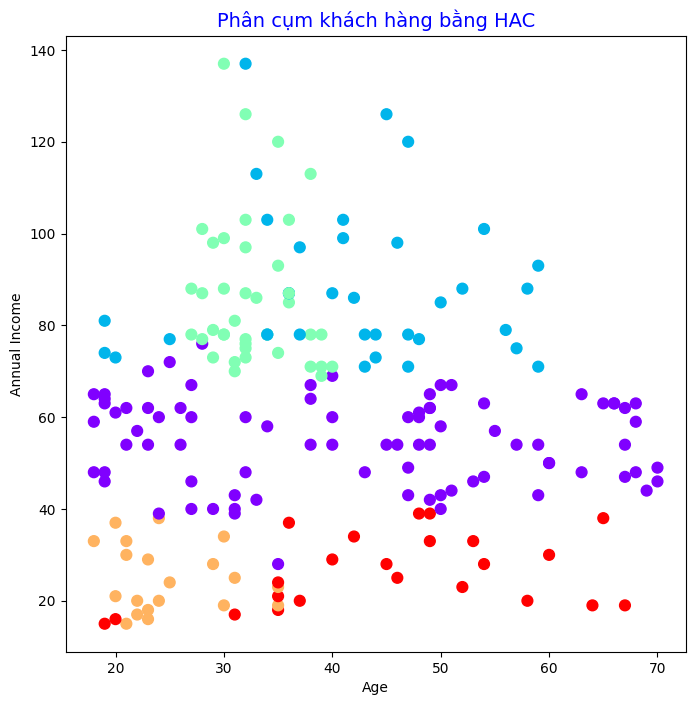

In [34]:
##-----------------------------------------------------------
## 7. Biểu diễn trực quan
##-----------------------------------------------------------
plt.figure(figsize=(8, 8))
plt.scatter(data['Age'], data['Annual Income'], c=data['cluster'], cmap='rainbow', s=60)
plt.title("Phân cụm khách hàng bằng HAC", fontsize=14, color='blue')
plt.xlabel("Age")
plt.ylabel("Annual Income")
plt.show()

# I. Giải thích chi tiết lý thuyết HAC (Hierarchical Agglomerative Clustering)
## 1. Ý tưởng chính
- Hierarchical Clustering (HC) là kỹ thuật gom cụm dựa trên mối quan hệ phân cấp giữa các điểm dữ liệu — nghĩa là bạn có thể hình dung dữ liệu được gom dần thành một “cây phân cấp” (Dendrogram 🌳).

- HC có 2 hướng tiếp cận:

| Phương pháp                       | Hướng đi                 | Ý nghĩa                                                                                         |
| --------------------------------- | ------------------------ | ----------------------------------------------------------------------------------------------- |
| **AGNES (Agglomerative Nesting)** | Bottom-Up (từ dưới lên)  | Mỗi điểm bắt đầu là một cụm riêng → liên tục gộp hai cụm gần nhau nhất → thành một cụm lớn hơn. |
| **DIANA (Divisive Analysis)**     | Top-Down (từ trên xuống) | Bắt đầu với 1 cụm duy nhất → chia tách dần thành các cụm con nhỏ hơn.                           |

- Thông thường, AGNES là phương pháp phổ biến nhất và được gọi chung là Hierarchical Agglomerative Clustering (HAC).


## 2. Các bước của AGNES (HAC)
- Giả sử có n điểm dữ liệu:
    - Bước 1️⃣ — Khởi tạo:
        - Mỗi điểm dữ liệu là một cụm riêng → có n cụm ban đầu.
    - Bước 2️⃣ — Tính khoảng cách giữa các cụm:
        - Khoảng cách có thể tính theo:
            - Single-link (liên kết đơn): khoảng cách nhỏ nhất giữa 2 cụm.
            - Complete-link: khoảng cách lớn nhất giữa 2 cụm.
            - Average-link: trung bình các khoảng cách giữa các điểm của 2 cụm.
            - Ward’s method: dựa trên phương sai tổng thể (thường cho kết quả “mượt” hơn).
    - Bước 3️⃣ — Gộp 2 cụm gần nhau nhất lại.
        - Số cụm giảm đi 1.

    - Bước 4️⃣ — Lặp lại bước 2 và 3 cho đến khi tất cả gộp thành 1 cụm duy nhất.
    - Bước 5️⃣ — Vẽ Dendrogram để biểu diễn quá trình gom cụm.

👉 Dendrogram là biểu đồ dạng cây, cho phép “cắt ngang” ở một mức chiều cao để chọn số cụm mong muốn (ví dụ: cắt tại ngưỡng y = 200 để tạo ra 5 cụm).

## 3. Đánh giá phương pháp HAC
| Ưu điểm                                     | Nhược điểm                                                |
| ------------------------------------------- | --------------------------------------------------------- |
| Không cần chọn trước số cụm K               | Không thể quay lui sau khi gộp                            |
| Kết quả dễ hiểu, trực quan qua Dendrogram   | Độ phức tạp cao O(n²) → không phù hợp với tập dữ liệu lớn |
| Dễ hiển thị quan hệ giữa các cụm            | Nhạy cảm với dữ liệu nhiễu hoặc thiếu                     |
| Có thể phát hiện cấu trúc phân cấp tự nhiên | Không hiệu quả cho dữ liệu không lồi (non-convex)         |


## 4. Ví dụ trực quan
Giả sử bạn có 5 khách hàng với “Tuổi” và “Thu nhập” như sau:

| ID | Tuổi | Thu nhập |
| -- | ---- | -------- |
| 1  | 20   | 15       |
| 2  | 22   | 17       |
| 3  | 35   | 50       |
| 4  | 40   | 52       |
| 5  | 60   | 80       |

➡ Lúc đầu có 5 cụm (mỗi khách hàng 1 cụm).
➡ AGNES sẽ gộp 1 & 2 (vì gần nhất), sau đó gộp (3,4), rồi (1,2) với (3,4), cuối cùng (5) nhập vào.
➡ Dendrogram biểu diễn chính xác quá trình này.